/var/folders/vd/2swg53z14tdgd79bl4kjts180000gn/T/ipykernel_77684/50342551.py:173: UserWarning: Using a target size (torch.Size([131])) that is different to the input size (torch.Size([131, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = -(logp*adv).mean() + F.mse_loss(vals, returns)


Ep 20/300: Loss=-0.0121, Return=0.0190
Ep 40/300: Loss=-0.1030, Return=0.0490
Ep 60/300: Loss=-0.0935, Return=0.0163
Ep 80/300: Loss=0.1126, Return=0.1768
Ep 100/300: Loss=-0.0946, Return=0.0694
Ep 120/300: Loss=-0.0280, Return=0.0332
Ep 140/300: Loss=0.0430, Return=0.1277
Ep 160/300: Loss=0.0793, Return=0.1116
Ep 180/300: Loss=0.2072, Return=0.2181
Ep 200/300: Loss=-0.0360, Return=0.0696
Ep 220/300: Loss=-0.0741, Return=0.0012
Ep 240/300: Loss=-0.0920, Return=0.0405
Ep 260/300: Loss=0.0650, Return=0.1176
Ep 280/300: Loss=-0.0021, Return=0.1086
Ep 300/300: Loss=-0.0152, Return=0.1226

=== Testing 2016-01-01 → 2018-01-01 ===
Running MVO backtest with 252-day rolling window...
                        MVO        RL
Cumulative Return  0.389456  0.437897
Ann. Return        0.247968  0.274521
Ann. Vol           0.095495  0.077435
Sharpe             2.320691  3.134075
Max DD            -0.111918 -0.050593


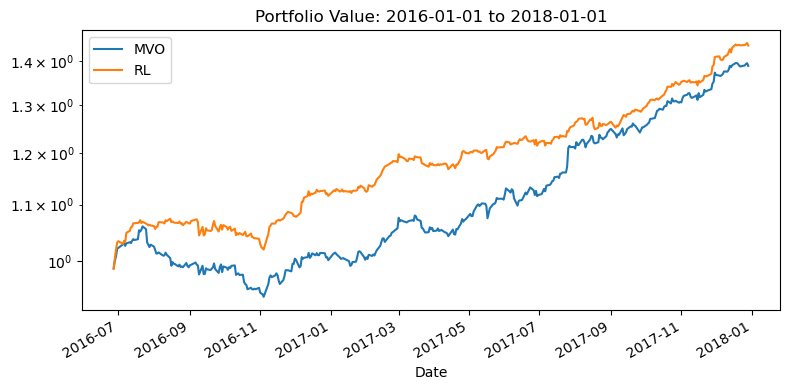


=== Testing 2018-01-01 → 2020-01-01 ===
Running MVO backtest with 252-day rolling window...
                        MVO        RL
Cumulative Return  0.133055  0.282908
Ann. Return        0.099446  0.189655
Ann. Vol           0.157512  0.136650
Sharpe             0.602016  1.271304
Max DD            -0.170816 -0.156375


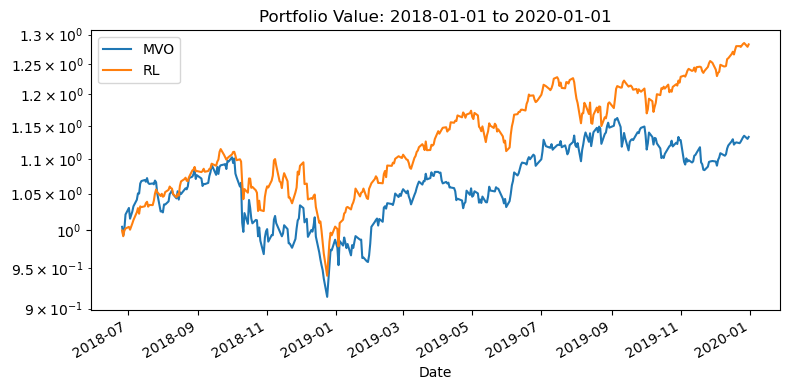


=== Testing 2020-01-01 → 2023-01-01 ===
Running MVO backtest with 252-day rolling window...
                        MVO        RL
Cumulative Return  0.533761  0.414340
Ann. Return        0.220612  0.163908
Ann. Vol           0.239352  0.163488
Sharpe             0.833211  0.928690
Max DD            -0.203474 -0.199612


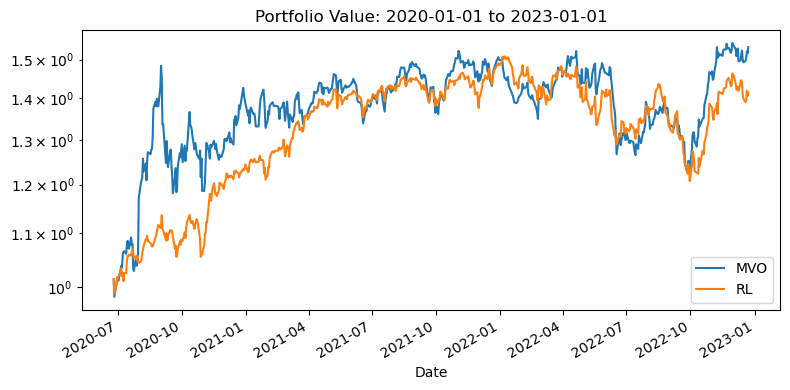

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.optimize import minimize

#prices
def load_price_data(folder_pattern, start_date, end_date):
    files = glob.glob(folder_pattern)
    dfs = []
    for file in files:
        symbol = os.path.splitext(os.path.basename(file))[0]
        df = pd.read_csv(file, parse_dates=['Date'])
        mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
        df = df.loc[mask, ['Date', 'Adj Close']].set_index('Date')
        df.rename(columns={'Adj Close': symbol}, inplace=True)
        dfs.append(df)
    return pd.concat(dfs, axis=1).sort_index()

# here, we load and align sentiment data
def load_sentiment(file_path, price_index, tickers):
    sent = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)
    sent = sent.groupby(['date', 'stock'])['sentiment_score'].mean().unstack(fill_value=0)
    sent = sent.reindex(columns=tickers, fill_value=0)
    sent = sent.reindex(price_index, fill_value=0)
    return sent

# random weights
def generate_actions(n_assets, n_actions=50, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # sample on simplex via Dirichlet for performance
    return np.random.dirichlet(np.ones(n_assets), size=n_actions)

# portfolio environment
class PortfolioEnv:
    def __init__(self, price_df, sent_df, window_obs=60, window_state=120, lam=0.0):
        assert price_df.index.equals(sent_df.index)
        self.price_arr = price_df.values
        self.sent_arr  = sent_df.values
        self.window_obs, self.window_state = window_obs, window_state
        self.n_assets, self.lam = price_df.shape[1], lam
        self.reset()

    def reset(self):
        self.step_idx = max(self.window_obs, self.window_state)
        self.port_val = 1.0
        self.history = [self.port_val]
        return self._get_state()

    def step(self, action):
        assert len(action) == self.n_assets
        p = self.price_arr[self.step_idx]
        p_next = self.price_arr[self.step_idx+1]
        ret = (p_next/p) - 1
        raw_rew = action.dot(ret)
        if self.lam:
            s = action.dot(self.sent_arr[self.step_idx])
            reward = raw_rew + self.lam * s
        else:
            reward = raw_rew
        self.port_val *= (1+raw_rew)
        self.history.append(self.port_val)
        self.step_idx += 1
        done = self.step_idx >= len(self.price_arr)-1
        return self._get_state(), reward, done, {}

    def _get_state(self):
        i = self.step_idx
        #returns window
        prices = self.price_arr[i-self.window_obs:i]
        price_ret = np.diff(prices, axis=0) / prices[:-1]
        if price_ret.shape[0] < self.window_obs:
            pad = np.zeros((self.window_obs-price_ret.shape[0], self.n_assets))
            price_ret = np.vstack((pad, price_ret))
        price_ret = price_ret.T[np.newaxis]

        #sentiment window
        sent_win = self.sent_arr[i-self.window_obs:i].T[np.newaxis]

        #history window
        hist = np.log(np.array(self.history[1:]) / np.array(self.history[:-1]))
        if len(hist) < self.window_state:
            hist = np.pad(hist, (self.window_state-len(hist),0))
        else:
            hist = hist[-self.window_state:]
        hist = hist[np.newaxis, np.newaxis]

        return (
            torch.tensor(price_ret, dtype=torch.float32),
            torch.tensor(sent_win, dtype=torch.float32),
            torch.tensor(hist, dtype=torch.float32)
        )

class RLPortfolioManager(nn.Module):
    def __init__(self, n_price, obs_price, n_sent, obs_sent, n_state, obs_state, n_actions):
        super().__init__()
        #price conv
        self.p_conv = nn.Sequential(
            nn.Conv1d(n_price, 32, 3), nn.ReLU(),
            nn.Conv1d(32, 32, 3), nn.ReLU()
        )
        p_len = obs_price-4
        self.p_fc = nn.Linear(32*p_len, 128)
        #sentiment conv
        self.s_conv = nn.Sequential(
            nn.Conv1d(n_sent,16,3), nn.ReLU(),
            nn.Conv1d(16,16,3), nn.ReLU()
        )
        s_len = obs_sent-4
        self.s_fc = nn.Linear(16*s_len, 128)
        #history conv
        self.h_conv = nn.Sequential(
            nn.Conv1d(n_state,16,3), nn.ReLU(),
            nn.Conv1d(16,16,3), nn.ReLU()
        )
        h_len = obs_state-4
        self.h_fc = nn.Linear(16*h_len, 128)
        #all combined
        self.fc = nn.Linear(128*3, 128)
        self.policy = nn.Linear(128, n_actions)
        self.value  = nn.Linear(128, 1)

    def forward(self, p, s, h):
        #price branch
        x1 = self.p_conv(p).flatten(1)
        x1 = F.relu(self.p_fc(x1))
        #sentiment branch
        x2 = self.s_conv(s).flatten(1)
        x2 = F.relu(self.s_fc(x2))
        #history branch
        x3 = self.h_conv(h).flatten(1)
        x3 = F.relu(self.h_fc(x3))
        #combine
        x = torch.cat([x1,x2,x3], dim=1)
        x = F.relu(self.fc(x))
        return self.policy(x), self.value(x)

# training loop
def train_agent(net, opt, actions, price_df, sent_df,
                episodes=200, window_obs=60, window_state=120,
                gamma=0.99, lam=0.0, device='cpu'):
    net.to(device)
    for ep in range(episodes):
        idx = np.random.randint(0, len(price_df)-252)
        pr_ep = price_df.iloc[idx:idx+252].reset_index(drop=True)
        se_ep = sent_df.iloc[idx:idx+252].reset_index(drop=True)
        env = PortfolioEnv(pr_ep, se_ep, window_obs, window_state, lam)
        state = env.reset()
        logp, vals, rews = [], [], []
        done=False
        while not done:
            p,s,h = [t.to(device) for t in state]
            logits, val = net(p,s,h)
            probs = F.softmax(logits, dim=1)
            m = torch.distributions.Categorical(probs)
            a = m.sample()
            logp.append(m.log_prob(a))
            vals.append(val.squeeze(1))
            state, r, done, _ = env.step(actions[a.item()])
            rews.append(r)
        # returns computation
        R, ret_list = 0, []
        for r in reversed(rews): R = r + gamma*R; ret_list.insert(0,R)
        returns = torch.tensor(ret_list, dtype=torch.float32, device=device)
        vals = torch.stack(vals)
        logp = torch.stack(logp)
        adv = returns - vals.detach()
        loss = -(logp*adv).mean() + F.mse_loss(vals, returns)
        opt.zero_grad(); loss.backward(); opt.step()
        if (ep+1)%20==0:
            print(f"Ep {ep+1}/{episodes}: Loss={loss.item():.4f}, Return={sum(rews):.4f}")
    return net

# MVO
def calculate_mvo_weights(returns_df, risk_free_rate_daily=0.0):
    """
    Calculates max Sharpe ratio weights via daily returns mean/covariance.
    Implements original zero-volatility handling: if volatility is zero,
    returns -inf (best) when return > risk-free, else 0.
    """
    mu = returns_df.mean()
    Sigma = returns_df.cov()

    def neg_sharpe(weights):
        p_ret = np.dot(weights, mu)
        p_var = np.dot(weights.T, np.dot(Sigma, weights))
        p_vol = np.sqrt(p_var) if p_var > 0 else 0

        if p_vol == 0:
            return -np.inf if p_ret > risk_free_rate_daily else 0

        sharpe = (p_ret - risk_free_rate_daily) / p_vol
        return -sharpe  # minimize negative Sharpe ratio 

    # constraints: weights sum to 1 and weights between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(len(mu)))
    init_guess = np.ones(len(mu)) / len(mu)

    result = minimize(
        neg_sharpe,
        init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    if not result.success:
        print(f"Warning: MVO optimization failed ({result.message}). Using equal weights.")
        return init_guess
    return result.x

#MVO backtest
def run_mvo_backtest(price_data_full, test_period_data, lookback_window=252):
    """
    Runs the daily rolling MVO backtest on the test_period_data.
    Uses price_data_full for historical lookbacks.
    """
    print(f"Running MVO backtest with {lookback_window}-day rolling window...")
    returns_full = price_data_full.pct_change()
    test_dates = test_period_data.index
    n_assets = test_period_data.shape[1]
    asset_names = test_period_data.columns

    mvo_weights_history = pd.DataFrame(index=test_dates, columns=asset_names)
    mvo_portfolio_returns = pd.Series(index=test_dates)

    for current_date in test_dates:
        try:
            end_loc = returns_full.index.get_loc(current_date)
            lookback_end_loc = end_loc
            lookback_start_loc = lookback_end_loc - lookback_window

            if lookback_start_loc < 0:
                print(f"Warning: Not enough history for lookback window on {current_date}. Using equal weights.")
                weights_t = np.ones(n_assets) / n_assets
            else:
                hist_returns = returns_full.iloc[lookback_start_loc:lookback_end_loc].dropna()
                if len(hist_returns) < n_assets + 1:
                    print(f"Warning: Not enough non-NaN data points ({len(hist_returns)}) in lookback for {current_date}. Using equal weights.")
                    weights_t = np.ones(n_assets) / n_assets
                else:
                    weights_t = calculate_mvo_weights(hist_returns, risk_free_rate_daily=0.0)
        except KeyError:
            print(f"Warning: Date {current_date} not found in returns_full index. Skipping.")
            weights_t = np.ones(n_assets) / n_assets

        mvo_weights_history.loc[current_date] = weights_t

        try:
            actual_day_returns = returns_full.loc[current_date].fillna(0)
            daily_portfolio_return = np.dot(weights_t, actual_day_returns)
            mvo_portfolio_returns.loc[current_date] = daily_portfolio_return
        except KeyError:
            mvo_portfolio_returns.loc[current_date] = 0

    mvo_portfolio_returns = mvo_portfolio_returns.dropna()
    return mvo_portfolio_returns, mvo_weights_history

# RL backtest
def run_rl_backtest(net, actions, price_df, sent_df, window_obs=60, window_state=120, device='cpu'):
    net.to(device).eval()
    env = PortfolioEnv(price_df.reset_index(drop=True), sent_df.reset_index(drop=True), window_obs, window_state)
    state = env.reset()
    rets, dates = [], price_df.index[window_state+1:]
    done=False
    while not done:
        p,s,h = [t.to(device) for t in state]
        logits,_ = net(p,s,h)
        a = torch.argmax(F.softmax(logits,dim=1), dim=1).item()
        state, r, done, _ = env.step(actions[a])
        rets.append(r)
    return pd.Series(rets, index=dates[:len(rets)])

# metrics
def calculate_performance_metrics(daily_returns, rf_annual=0.0):
    dr = daily_returns.fillna(0)
    cum = (1+dr).prod()-1
    ann_ret = ((1+dr.mean())**252)-1
    ann_vol = dr.std()*np.sqrt(252)
    rf_daily = (1+rf_annual)**(1/252)-1
    sr = ((dr.mean()-rf_daily)/dr.std())*np.sqrt(252) if dr.std()>0 else np.nan
    dd = (1+dr).cumprod()
    mxdd = (dd/dd.cummax()-1).min()
    return pd.Series({'Cumulative Return':cum,'Ann. Return':ann_ret,'Ann. Vol':ann_vol,'Sharpe':sr,'Max DD':mxdd})

#main
if __name__ == "__main__":
    folder = os.path.join("stocks","datasets","dj30","raw","*.csv")
    prices = load_price_data(folder, '2010-01-01','2023-01-01')
    tickers = prices.columns.tolist()
    sens = load_sentiment("stocks_sentiment_scores.csv", prices.index, tickers)
    train_p = prices.loc['2010-01-01':'2016-01-01']
    train_s = sens.loc[train_p.index]
    actions = generate_actions(len(tickers), 50, seed=42)
    net = RLPortfolioManager(len(tickers),60,len(tickers),60,1,120,actions.shape[0])
    opt = optim.Adam(net.parameters(), lr=1e-4)
    net = train_agent(net, opt, actions, train_p, train_s,
                      episodes=300, lam=0.05)
    test_periods = [
        ('2016-01-01','2018-01-01'),
        ('2018-01-01','2020-01-01'),
        ('2020-01-01','2023-01-01'),
    ]
    for start, end in test_periods:
        print(f"\n=== Testing {start} → {end} ===")
        test_p = prices.loc[start:end]
        test_s = sens.loc[test_p.index]
        mvo_rets, _ = run_mvo_backtest(prices, test_p)
        rl_rets = run_rl_backtest(net, actions, test_p, test_s)
        idx = mvo_rets.index.intersection(rl_rets.index)
        mvo_r, rl_r = mvo_rets.loc[idx], rl_rets.loc[idx]
        mvo_m = calculate_performance_metrics(mvo_r)
        rl_m  = calculate_performance_metrics(rl_r)
        comp = pd.DataFrame({'MVO': mvo_m, 'RL': rl_m})
        print(comp)
        plt.figure(figsize=(8,4))
        (1+mvo_r).cumprod().plot(label='MVO')
        (1+rl_r).cumprod().plot(label='RL')
        plt.title(f"Portfolio Value: {start} to {end}")
        plt.yscale('log'); plt.legend(); plt.tight_layout()
        plt.show()